This notebook is almost identical to  AstrometryMetricwithoutMAF-V4-WY-Copy1 except for the final plot that it outputs.

In [4]:
import math
import astropy
from astropy.io import ascii
import numpy as np
import emcee
import pandas as pd
from scipy.optimize import minimize
from numpy.random import normal
from numpy.random import uniform
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable
import richardsplot as rplot
%matplotlib inline
import random
from matplotlib import rc
rc('text', usetex=False)

## open file with photo-z PDF redshift bins

In [5]:
#BEE: read in table of redshifts and save the 'zshifts' column as a variable named zshifts
#BEE: zshifts is a list of redshifts from 0.4 to 4.0
#GTR: This is just a list of redshift bins

In [6]:
zshifts_Table = ascii.read('fittingS82_zshifts.dat', format='csv')
zshifts = zshifts_Table['zshifts']

## open file with regression values

In [7]:
#BEE: create an array of sdss features
#BEE: read in table of regression values, create array of zeros with shape(features, redshifts)
#BEE: fill array of zeros with data from regression values table
#GTR: These are the mean colors and DCR slopes for the above redshift bins

In [8]:
sdss_features = ['u-g', 'g-r', 'r-i', 'i-z']
sdss_features_dcr = ['u-g', 'g-r', 'r-i', 'i-z', 'u-slope', 'g-slope']

color_fit_Table = ascii.read('fittingS82_zshiftfit.dat')
color_fit_Table.remove_column('col1')
color_fit = np.zeros((len(sdss_features), len(zshifts)))
color_fit_dcr = np.zeros((len(sdss_features_dcr), len(zshifts)))
for i in range(len(sdss_features)):
    for j in range(len(zshifts)):
        color_fit[i,j] = np.asarray(color_fit_Table[i][j])

for i in range(len(sdss_features_dcr)):
    for j in range(len(zshifts)):
        color_fit_dcr[i,j] = np.asarray(color_fit_Table[i][j])

## open file with regression covariance values


In [9]:
#BEE: read in regression covariance data
#BEE: create array of zeros with shape (features, features, redshifts), fill it with covariance table data
#GTR: These are the covariances between each of the above parameters at each redshift

In [10]:
color_covariance_Table = ascii.read('fittingS82_zshiftcovariance.dat')
color_covariance_Table.remove_column('col1')
color_covariance_Table.remove_column('col2')
color_covariance = np.zeros((len(sdss_features), len(sdss_features), len(zshifts)))
color_covariance_dcr = np.zeros((len(sdss_features_dcr), len(sdss_features_dcr), len(zshifts)))  
l = 0
for i in range(len(sdss_features_dcr)):
    for j in range(len(sdss_features_dcr)):
        for k in range(len(zshifts)):
            color_covariance_dcr[i,j,k] = np.asarray(color_covariance_Table[l][k])
        l += 1
color_covariance = color_covariance_dcr[:4, :4, :]
#print(color_covariance_dcr)
#print(color_covariance)

In [11]:
#BEE: Read in simulated "true" quasar data
#GTR: These are simulated quasars with simulated parameters (and their errors)

### This is just picking out one quasar that is near the given redshift

In [12]:
#test_quasars0 = ascii.read('random_quasars.dat')
select_quasar = np.random.choice(100000)
test_quasars = ascii.read('random_quasars100k.dat')[select_quasar-1:select_quasar]
#print(test_quasars.keys())
select_redshift = 2.2
while abs(test_quasars['zspec'] - select_redshift) >= 0.1:
    select_quasar = np.random.choice(100000)
    test_quasars=ascii.read('random_quasars100k.dat')[select_quasar-1:select_quasar]
print(test_quasars['zspec'])

zspec 
------
2.2932


## open file with the simulated quasar true values

In [13]:
#BEE: this cell will take observations from the OpSim rather than simulating them
#GTR: Not sure exactly where this opSim information comes from.  Weixiang?
#id.csv is just an indexed list of RA and Dec
#dcr_all.csv is a list of observation parameters for each of those IDs
#this includes airmass and filter, which is all that we use right now?
#It seems that right now a random object is being chosen?
astrometric_error = [0.035, 0.025]
astrometric_error = np.multiply(astrometric_error, [2,2])
print(astrometric_error)
# Weixiang: import opsim cadence after fix for python2
ids = pd.read_csv('id.csv')
cad = pd.read_csv('dcr_all.csv')

#pick random object's cadence
random_cadence = random.randint(0,max(cad['id']))
# assign the cadence of random object to dcr_0
dcr_0 = cad[cad['id'] == random_cadence].copy()
obs_g = dcr_0[dcr_0['filter'] == 'g']
obs_u = dcr_0[dcr_0['filter'] == 'u']
obs = np.concatenate((obs_g, obs_u))


[0.07 0.05]


In [14]:
airmasses = np.array([item[3] for item in obs])
filters = np.array([item[5] for item in obs])

In [15]:
#GTR: Let's not do that experiment any more and just explore the different opSims.  
#So either take this out or just leave the array blank.

In [16]:
experiment_to_run = 'addition'
#experiment_to_run = 'substitution'
#experiment_to_run = 'addition'
airmass_to_use = []
if experiment_to_run == 'addition':
    filters_to_add = np.tile('g', int(len(airmass_to_use)))
    airmasses = np.append(airmasses, airmass_to_use)
    filters = np.append(filters, filters_to_add)
    save_file_name = 'AstroMetric_TwilightDCR_' + str([int(airmass_to_use[i]*10) for i in range(len(airmass_to_use))]) + '.npz'

## generate observed slopes from true slopes and observations

In [17]:
def lnlike(theta, x, y, yerr):
    m, lnf = theta
    model = m*x
    inv_sigma2 = 1.0/(yerr**2. + model**2.*np.exp(2.*lnf))
    return -0.5*(np.sum(((y-model)**2.*inv_sigma2 - np.log(inv_sigma2))))

def lnprior(theta):
    m, lnf = theta
    if (-1.0 < m < 1.0) and (-100.0 < lnf < 100.0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

def run_fit(tanZList, RList, RerrList):
    nll = lambda *args: -lnprob(*args)
    x = np.copy(tanZList)
    y = np.copy(RList)
    yerr = np.copy(RerrList)
    #first do a simple minimization to get starting values for mcmc
    pm = np.random.choice([-1.0,1.0], size=len(x), replace=True)
    result = minimize(nll, [-0.001, np.log(0.5)], args=(x, y, yerr))
    m_ml, lnf_ml = result["x"]
    #now run mcmc
    ndim, nwalkers = 2, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    ms = samples[np.random.randint(len(samples), size=100)][:,0]
    # return the median walker as the best slope and the half the 16-84th percentiles as the error
    m_mcmc, lnf_mcmc = map(lambda v: (v[1]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    merr_mcmc, lnf_mcmc = map(lambda v: (0.5*(v[2]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    return m_mcmc, merr_mcmc


In [18]:
def slopeProgressionCalc(airmasses, filters, test_quasars, makePlot=True):
    astrometric_error = [0.035, 0.025]
    obs_slopes_u    = np.zeros((len(test_quasars)))
    obs_slopes_uerr = np.zeros((len(test_quasars)))
    obs_slopes_g    = np.zeros((len(test_quasars)))
    obs_slopes_gerr = np.zeros((len(test_quasars)))
    diff_array_u = []
    diff_array_g = []
    num_obs_array_u = []
    num_obs_array_g = []
    imgNumString = 0
    xAxis = np.linspace(0, 2.0, 100)
    for i in range(len(test_quasars)):
        true_slope_u = test_quasars['u-slope'][i]
        true_slope_g = test_quasars['g-slope'][i]
        tanZList_u = np.array([])
        RerrList_u = np.array([])
        RList_u = np.array([])
        tanZList_g = np.array([])
        RerrList_g = np.array([])
        RList_g = np.array([])
        for j, airmass in enumerate(airmasses):
            tanZ_obs = np.tan(np.arccos(1.0/airmass)) #tangent of zenith angle of this observation
            if filters[j] == 'u':
                #calculate the observed offset
                #random scatter around the true offset using a normal distribution with the astrometric error as the standard deviation
                R_obs = normal(true_slope_u*tanZ_obs, astrometric_error[0])
                tanZList_u = np.append(tanZList_u, tanZ_obs)              #list of x axis values
                RerrList_u = np.append(RerrList_u, astrometric_error[0])  #list of y axis error values
                RList_u = np.append(RList_u, R_obs)                       #list of y axis values
            if filters[j] == 'g':
                R_obs = normal(true_slope_g*tanZ_obs, astrometric_error[1])
                tanZList_g = np.append(tanZList_g, tanZ_obs)
                RerrList_g = np.append(RerrList_g, astrometric_error[1])
                RList_g = np.append(RList_g, R_obs)
        NumObsPerBand = 2
        while ((NumObsPerBand <= len(tanZList_u)) or (NumObsPerBand <= len(tanZList_g))):
            if NumObsPerBand < len(tanZList_g):
                tanZList_g_copy = tanZList_g[:NumObsPerBand]
                RList_g_copy = RList_g[:NumObsPerBand]
                RerrList_g_copy = RerrList_g[:NumObsPerBand]
            else:
                tanZList_g_copy = tanZList_g
                RList_g_copy = RList_g
                RerrList_g_copy = RerrList_g
            if NumObsPerBand < len(tanZList_u):
                tanZList_u_copy = tanZList_u[:NumObsPerBand]
                RList_u_copy = RList_u[:NumObsPerBand]
                RerrList_u_copy = RerrList_u[:NumObsPerBand]
            else:
                tanZList_u_copy = tanZList_u
                RList_u_copy = RList_u
                RerrList_u_copy = RerrList_u
            m_mcmc_u, merr_mcmc_u = run_fit(tanZList_u_copy, RList_u_copy, RerrList_u_copy)
            m_mcmc_g, merr_mcmc_g = run_fit(tanZList_g_copy, RList_g_copy, RerrList_g_copy)
            slope_diff_u = abs(m_mcmc_u - true_slope_u)
            slope_diff_g = abs(m_mcmc_g - true_slope_g)
            if makePlot == True:
                bestFitLine_u = m_mcmc_u*xAxis + 0.0
                bestFitLine_g = m_mcmc_g*xAxis + 0.0
                trueFitLine_u = true_slope_u*xAxis + 0.0
                trueFitLine_g = true_slope_g*xAxis + 0.0
                plt.figure(figsize=(12,12))
                plt.subplot(121)
                plt.title(str(len(tanZList_u_copy))+' u-band observations + fit')
                plt.scatter(tanZList_u_copy[:NumObsPerBand-1], RList_u_copy[:NumObsPerBand-1], label = 'Observations', alpha=0.2)
                plt.scatter(tanZList_u_copy[-1], RList_u_copy[-1], label= 'New Observation', alpha=1.0, s=35)
                plt.plot(xAxis, bestFitLine_u, label='Fit Line')
                plt.plot(xAxis, trueFitLine_u, label = 'True Line')
                plt.legend(loc='upper right')
                plt.xlabel('Tan(Z)')
                plt.ylabel('delta R')
                plt.xlim(0.0, 2.0)
                plt.ylim(-0.2, 0.2)
                plt.subplot(122)
                plt.title(str(len(tanZList_g_copy))+' g-band observations + fit')
                plt.scatter(tanZList_g_copy[:NumObsPerBand-1], RList_g_copy[:NumObsPerBand-1], label = 'Observations', alpha=0.2)
                plt.scatter(tanZList_g_copy[-1], RList_g_copy[-1], label= 'New Observation', alpha=1.0, s=35)
                plt.plot(xAxis, bestFitLine_g, label = 'Fit Line')
                plt.plot(xAxis, trueFitLine_g, label = 'True Line')
                plt.legend(loc='upper right')
                plt.xlabel('Tan(Z)')
                plt.xlim(0.0, 2.0)
                plt.ylim(-0.2, 0.2)
                #filename = "TanZimgFiles/airmassOffsetFit"+str(len(airmasses))+"_"+"{:0>5d}".format(imgNumString)
                filename= "TanZSequenceFiles/airmassOffsetFit_Sequence_"+"{:0>5d}".format(imgNumString)
                plt.savefig(filename)
                plt.clf()
                plt.close()
                imgNumString += 1
            diff_array_u = np.append(diff_array_u, slope_diff_u)
            diff_array_g = np.append(diff_array_g, slope_diff_g)
            num_obs_array_u = np.append(num_obs_array_u, len(tanZList_u_copy))
            num_obs_array_g = np.append(num_obs_array_g, len(tanZList_g_copy))
            NumObsPerBand += 1
    return diff_array_u, diff_array_g, num_obs_array_u, num_obs_array_g
    

In [22]:
diff_array_u, diff_array_g, num_obs_array_u, num_obs_array_g = slopeProgressionCalc(airmasses, filters, test_quasars, True)

2.2932


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


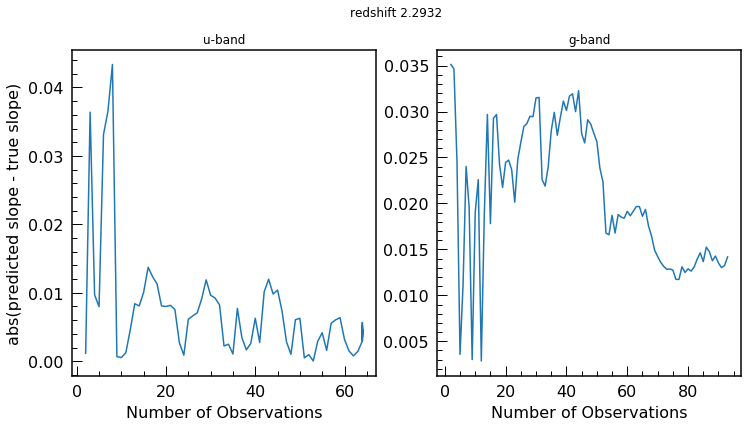

In [20]:
print(test_quasars['zspec'][0])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(num_obs_array_u, diff_array_u)
plt.ylabel('abs(predicted slope - true slope)')
plt.xlabel('Number of Observations')
plt.title('u-band'+str())
plt.subplot(122)
plt.plot(num_obs_array_g, diff_array_g)
plt.xlabel('Number of Observations')
plt.title('g-band')
plt.suptitle('redshift ' + str(test_quasars['zspec'][0]))
plt.savefig('DiffSlopevRedshift/diffSlopevRedshift' + str(test_quasars['zspec'][0])[0] + str(test_quasars['zspec'][0])[2] + '.png')

In [13]:
number_to_leave = 2
while number_to_leave <= 40:
    airmasses_copy = airmasses
    filters_copy = filters
    if number_to_leave != "all":
        #save_file_name = save_file_name[:-4] + "_" + str(number_to_leave) + "obs" + save_file_name[-4:]
        #print("file name is " + save_file_name)
        number_to_remove = len(airmasses_copy) - number_to_leave
    else:
        number_to_remove = 0
    removed = 0
    random.seed(123011)
    while removed < number_to_remove:
        remove_index = random.randint(0,len(airmasses_copy)-1)
        airmasses_copy = np.delete(airmasses_copy, remove_index)
        filters_copy = np.delete(filters_copy, remove_index)
        removed += 1 
    obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr = dcrSlopeCalc(airmasses_copy, filters_copy, test_quasars)
    number_to_leave+=1

NameError: name 'dcrSlopeCalc' is not defined

In [ ]:
def dcrSlopeCalc(airmasses, filters, test_quasars, makePlot = True):
    astrometric_error = [0.035, 0.025]
    obs_slopes_u    = np.zeros((len(test_quasars)))
    obs_slopes_uerr = np.zeros((len(test_quasars)))
    obs_slopes_g    = np.zeros((len(test_quasars)))
    obs_slopes_gerr = np.zeros((len(test_quasars)))
    imgNumString = 0
    xAxis = np.linspace(0, 2.0, 100)
    for i in range(len(test_quasars)):
        true_slope_u = test_quasars['u-slope'][i]
        true_slope_g = test_quasars['g-slope'][i]
    
        tanZList_u = np.array([])
        RerrList_u = np.array([])
        RList_u = np.array([])
        tanZList_g = np.array([])
        RerrList_g = np.array([])
        RList_g = np.array([])
    
        for j, airmass in enumerate(airmasses):
            tanZ_obs = np.tan(np.arccos(1.0/airmass)) #tangent of zenith angle of this observation
            if filters[j] == 'u':
                #calculate the observed offset
                #random scatter around the true offset using a normal distribution with the astrometric error as the standard deviation
                R_obs = normal(true_slope_u*tanZ_obs, astrometric_error[0])
                tanZList_u = np.append(tanZList_u, tanZ_obs)              #list of x axis values
                RerrList_u = np.append(RerrList_u, astrometric_error[0])  #list of y axis error values
                RList_u = np.append(RList_u, R_obs)                       #list of y axis values
            if filters[j] == 'g':
                R_obs = normal(true_slope_g*tanZ_obs, astrometric_error[1])
                tanZList_g = np.append(tanZList_g, tanZ_obs)
                RerrList_g = np.append(RerrList_g, astrometric_error[1])
                RList_g = np.append(RList_g, R_obs)
    
        # fit a stright line through the x and y values, using the y-err values
        m_mcmc_u, merr_mcmc_u = run_fit(tanZList_u, RList_u, RerrList_u)
        m_mcmc_g, merr_mcmc_g = run_fit(tanZList_g, RList_g, RerrList_g)
        if makePlot == True:
            bestFitLine_u = m_mcmc_u*xAxis + 0.0
            bestFitLine_g = m_mcmc_g*xAxis + 0.0
            trueFitLine_u = true_slope_u*xAxis + 0.0
            trueFitLine_g = true_slope_g*xAxis + 0.0
            plt.figure(figsize=(12,12))
            plt.subplot(121)
            plt.title(str(len(tanZList_u))+' u-band observations + fit')
            plt.scatter(tanZList_u, RList_u, label = 'Observations')
            plt.plot(xAxis, bestFitLine_u, label='Fit Line')
            plt.plot(xAxis, trueFitLine_u, label = 'True Line')
            plt.legend()
            plt.xlabel('Tan(Z)')
            plt.ylabel('delta R')
            plt.xlim(0.0, 2.0)
            plt.ylim(-0.2, 0.2)
            plt.scatter(x=tanZList_u, y=RList_u)
            plt.subplot(122)
            plt.title(str(len(tanZList_g))+' g-band observations + fit')
            print(tanZList_g)
            print(RList_g)
            plt.scatter(tanZList_g, RList_g, label = 'Observations')
            plt.plot(xAxis, bestFitLine_g, label = 'Fit Line')
            plt.plot(xAxis, trueFitLine_g, label = 'True Line')
            plt.xlabel('Tan(Z)')
            plt.xlim(0.0, 2.0)
            plt.ylim(-0.2, 0.2)
            plt.scatter(x=tanZList_g, y=RList_g)
            #filename = "TanZimgFiles/airmassOffsetFit"+str(len(airmasses))+"_"+"{:0>5d}".format(imgNumString)
            filename= "TanZimgFiles/airmassOffsetFit_Adding_"+str(len(airmasses))+"_"+"{:0>5d}".format(imgNumString)
            plt.savefig(filename)
            plt.clf()
            plt.close()
            imgNumString += 1
        obs_slopes_u[i] = m_mcmc_u
        obs_slopes_uerr[i] = merr_mcmc_u
        obs_slopes_g[i] = m_mcmc_g
        obs_slopes_gerr[i] = merr_mcmc_g
    '''
    if makePlot == True:
        deltaSlope_u = []
        deltaSlope_g = []
        for i in range(len(obs_slopes_u)):
            deltaSlope_u = np.append(deltaSlope_u, test_quasars['u-slope'][i] - obs_slopes_u[i])
        for i in range(len(obs_slopes_g)):
            deltaSlope_g = np.append(deltaSlope_g, test_quasars['g-slope'][i] - obs_slopes_g[i])
        plt.figure(figsize=(12,12))
        plt.subplot(121)
        plt.hist(deltaSlope_u, bins=50, range=(-0.3,0.3))
        plt.title('Delta Slope u-band '+str(len(airmasses)))
        plt.subplot(122)
        plt.hist(deltaSlope_g, bins=50, range=(-0.3,0.3))
        plt.title('Delta Slope g-band '+str(len(airmasses)))
        filename = "DeltaSlopeimgFiles/deltaSlopeHist" + str(len(airmasses))
        plt.savefig(filename)
    '''
    return obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr

In [ ]:
#airmass removal cell
print(len(airmasses))
#if you don't want to remove any, set number_to_leave to "all"
number_to_leave = 20
if number_to_leave != "all":
    save_file_name = save_file_name[:-4] + "_" + str(number_to_leave) + "obs" + save_file_name[-4:]
    print("file name is " + save_file_name)
    number_to_remove = len(airmasses) - number_to_leave
else:
    number_to_remove = 0
removed = 0
while removed < number_to_remove:
    remove_index = random.randint(0,len(airmasses)-1)
    airmasses = np.delete(airmasses, remove_index)
    filters = np.delete(filters, remove_index)
    removed += 1 

In [ ]:
if experiment_to_run != 'colors':
    obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr = dcrSlopeCalc(airmasses, filters, test_quasars)
    obs_parameters = np.vstack([test_quasars['u-g'], test_quasars['g-r'], test_quasars['r-i'], test_quasars['i-z'], obs_slopes_u, obs_slopes_g, test_quasars['uerr'], test_quasars['gerr'], test_quasars['rerr'], test_quasars['ierr'], test_quasars['zerr'], obs_slopes_uerr, obs_slopes_gerr])
    deltaSlope_u = np.subtract(test_quasars['u-slope'], obs_slopes_u)
    deltaSlope_g = np.subtract(test_quasars['g-slope'], obs_slopes_g)
else:
    obs_parameters = np.vstack([test_quasars['u-g'], test_quasars['g-r'], test_quasars['r-i'], test_quasars['i-z'], test_quasars['uerr'], test_quasars['gerr'], test_quasars['rerr'], test_quasars['ierr'], test_quasars['zerr']])
